### Visualization examples

In [1]:
import xarray as xr
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from shared.data import SAT1_STAGES_ACCURACY, SAT1_STAGES_SPEED
import numpy as np
from xhistogram.xarray import histogram
import tensorflow as tf
from shared.models import SAT1Base
import visualkeras
from shared.training import split_data_on_participants, train_and_evaluate
from shared.normalization import *

#### Unprocessed distribution test

In [2]:
data_path_unprocessed = Path("data/sat1/split_stage_data_unprocessed.nc")
data_unprocessed = xr.load_dataset(data_path_unprocessed)

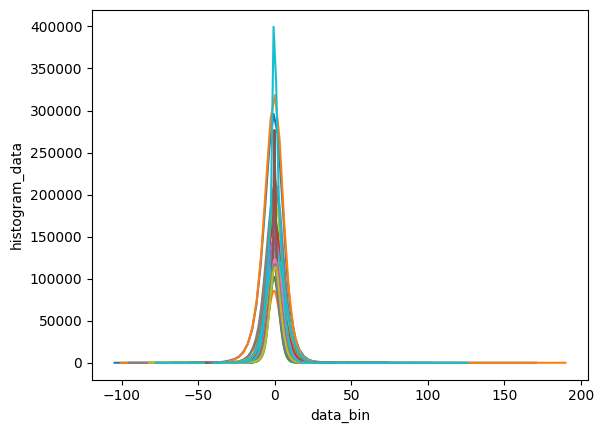

In [3]:
# Checking distribution for each channels
for channel in data_unprocessed.channels:
    data_subset = data_unprocessed.sel(channels=channel)
    max = data_subset.max().data.item()
    min = data_subset.min().data.item()
    bins = np.linspace(min, max, 100)
    hist = histogram(data_subset.data, bins=bins, block_size=data_subset.samples.size)
    # display(hist)
    hist.plot()

### Distribution test

In [4]:
data_path = Path("data/sat1/split_stage_data.nc")
data = xr.load_dataset(data_path)

<xarray.DataArray 'histogram_data' (data_bin: 59)>
array([      3,       2,       2,       4,       8,       6,      12,
            26,      27,      39,      55,      98,     114,     171,
           260,     440,     758,    1332,    2340,    4103,    7639,
         14116,   26485,   48994,   91271,  168041,  306014,  534380,
        879064, 1304783, 1644998, 1675957, 1373503,  943238,  577483,
        332953,  186343,  104006,   58268,   32849,   19150,   11221,
          6652,    3887,    2321,    1444,     892,     501,     284,
           204,     118,      77,      30,      34,      18,      14,
             6,       0,       2])
Coordinates:
  * data_bin  (data_bin) float64 -60.61 -58.63 -56.65 ... 50.32 52.3 54.28

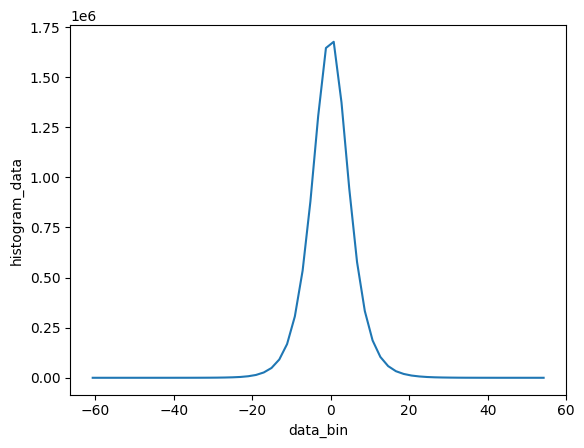

In [3]:
# Histogram of all values in dataset
# EEG data is already re-referenced to average value in preprocessing, so should be close to normal
max = data.max().data.item()
min = data.min().data.item()
bins = np.linspace(min, max, 60)
hist = histogram(data.data, bins=bins, block_size=data.samples.size)
display(hist)
hist.plot()

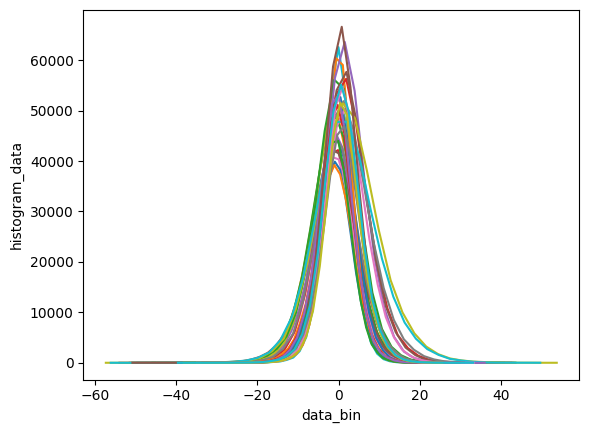

In [36]:
# Checking distribution for each channels, this means no within channel normalization is necessary
for channel in data.channels:
    data_subset = data.sel(channels=channel)
    max = data_subset.max().data.item()
    min = data_subset.min().data.item()
    bins = np.linspace(min, max, 40)
    hist = histogram(data_subset.data, bins=bins, block_size=data_subset.samples.size)
    # display(hist)
    hist.plot()

In [ ]:
sample_length = data.sel(channels="Fp1").data.isnull().idxmax("samples")
# Count occurences where length of samples for a label is higher than 100
np.count_nonzero(~np.isnan(sample_length.where(sample_length > 100).to_numpy()))

### Stage duration visualization

In [2]:
data_path = Path("data/sat1/split_stage_data.nc")
data = xr.load_dataset(data_path)

In [3]:
acc_data = data.where(data.cue == "AC", drop=True)
sp_data = data.where(data.cue == "SP", drop=True)

In [4]:
max_idx_acc = (
    acc_data.sel(channels="Fp1", labels=SAT1_STAGES_ACCURACY)
    .data.isnull()
    .idxmax("samples")
)
avg_acc = max_idx_acc.where(max_idx_acc != 0).mean(dim="epochs", skipna=True)

max_idx_sp = (
    sp_data.sel(channels="Fp1", labels=SAT1_STAGES_ACCURACY)
    .data.isnull()
    .idxmax("samples")
)
avg_sp = max_idx_sp.where(max_idx_sp != 0).mean(dim="epochs", skipna=True)

In [6]:
# max_idx_acc = acc_data.sel(channels="Fp1").data.isnull().idxmax("samples")
# avg_acc = max_idx_acc.where(max_idx_acc != 0).mean(dim="epochs", skipna=True)

# max_idx_sp = sp_data.sel(channels="Fp1").data.isnull().idxmax("samples")
# avg_sp = max_idx_sp.where(max_idx_sp != 0).mean(dim="epochs", skipna=True)

/home/rick/miniconda3/envs/thesis/lib/python3.11/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/home/rick/miniconda3/envs/thesis/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1559: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a,


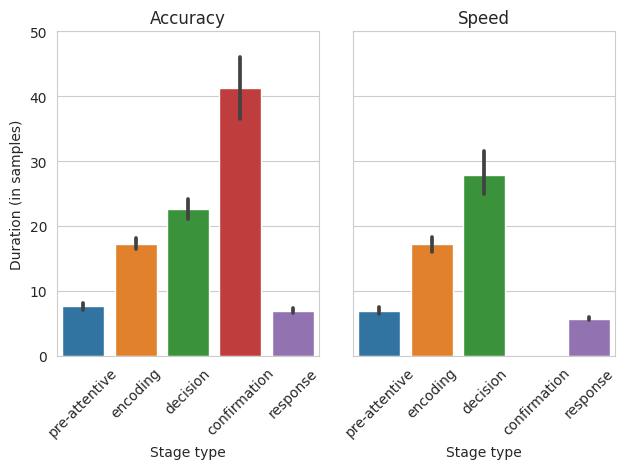

In [5]:
sns.set_style("whitegrid")

# sns.set_theme()
plt.rcParams["figure.autolayout"] = True
f, axes = plt.subplots(1, 2)

plt.setp(axes, ylim=(0, 50), xlabel="Stage type")

plot1 = sns.barplot(avg_acc, ax=axes[0])
plot2 = sns.barplot(avg_sp, ax=axes[1])

plot1.set_xticklabels(avg_acc.labels.to_numpy(), rotation=45)
plot1.set_ylabel("Duration (in samples)")
plot1.set_title("Accuracy")

plot2.set_xticklabels(avg_sp.labels.to_numpy(), rotation=45)
plot2.set_yticklabels([])
plot2.set_title("Speed")

plt.show()

In [3]:
model = SAT1Base(len(data.channels), len(data.samples), len(data.labels))
model.compile(
    optimizer=tf.keras.optimizers.Nadam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"],
)

2023-09-15 13:05:19.870230: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:07:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-09-15 13:05:19.901566: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:07:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-09-15 13:05:19.901635: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:07:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-09-15 13:05:19.904523: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:07:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-09-15 13:05:19.904584: I tensorflow/compile

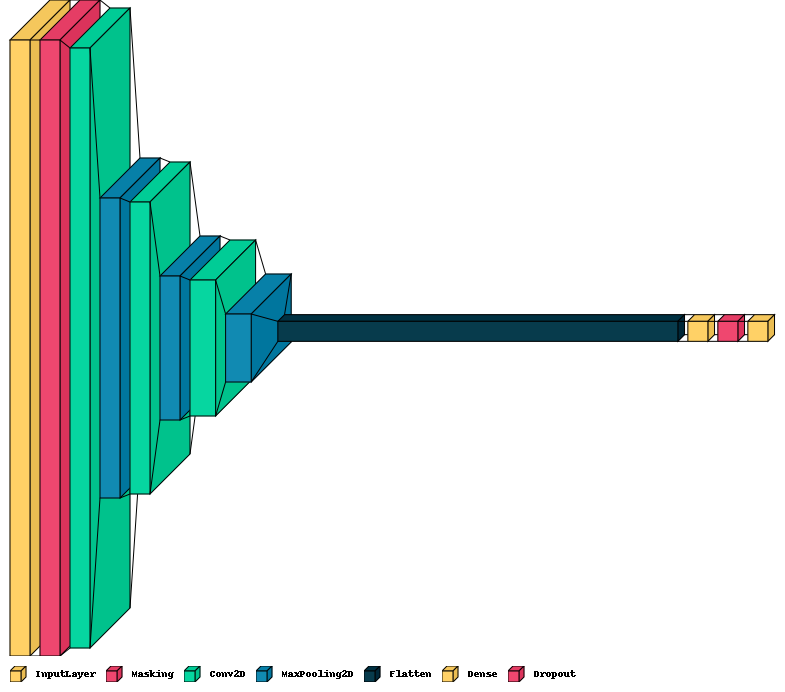

In [5]:
visualkeras.layered_view(model, legend=True)